<a href="https://colab.research.google.com/github/Jun0S2/AIBootcamp/blob/Week1-Basic/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

## [MY CODE] Test Data 준비하기 (1)

In [38]:
transform = transforms.ToTensor()
#  MNIST의 train data를 train=False로 설정
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

10000
torch.Size([1, 28, 28]) 7


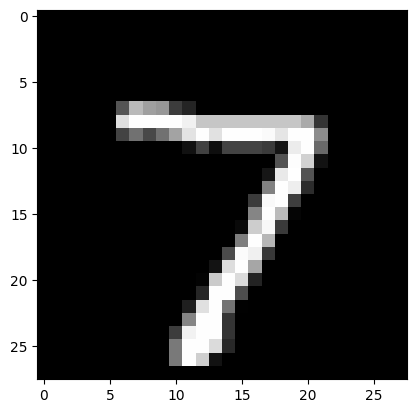

In [39]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

## [MY CODE] Test Data 준비하기 (2)

In [40]:
batch_size = 64

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# testloader 추가 (Dataloader 생성)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False      # 테스트 데이터는 섞을 필요가 없음
)


PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [41]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

## [MY CODE] 모델 및 손실 함수 변경

In [42]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # Output size = 10 (number of classes)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # x = self.act(self.layer3(x))
    x = self.layer3(x)  # No activation on output layer

    return x


model = Model(28 * 28 * 1, 1024).to('cuda')

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [43]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

## [My Code] 정확도 계산

In [44]:
# [MY CODE] 정확도 계산 함수
def accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # 가장 확률이 높은 클래스를 예측
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# [MY CODE] Train/Test 정확도 측정
train_acc = accuracy(model, trainloader)
test_acc = accuracy(model, testloader)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.0756
Test Accuracy: 0.0756


In [46]:
n_epochs = 100
train_accs, test_accs = [], []  # 정확도 리스트

for epoch in range(n_epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0.0

    for data in trainloader:
        model.zero_grad() # 기존 기울기를 초기화 ->이거 있어야지 정확한gradient 학습
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs)  # 모델 예측값
        loss = criterion(outputs, labels)  # 손실 함수

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 정확도 계산 (Epoch 끝난 후)
    train_acc = accuracy(model, trainloader)  # Train 정확도
    test_acc = accuracy(model, testloader)    # Test 정확도
    train_accs.append(train_acc)  # Train 정확도 기록
    test_accs.append(test_acc)    # Test 정확도 기록

    print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch   1/100 | Loss: 361.1340 | Train Acc: 0.1157 | Test Acc: 0.1157
Epoch   2/100 | Loss: 359.3306 | Train Acc: 0.2270 | Test Acc: 0.2270
Epoch   3/100 | Loss: 357.5157 | Train Acc: 0.3825 | Test Acc: 0.3825
Epoch   4/100 | Loss: 355.6626 | Train Acc: 0.4986 | Test Acc: 0.4986
Epoch   5/100 | Loss: 353.7457 | Train Acc: 0.5718 | Test Acc: 0.5718
Epoch   6/100 | Loss: 351.7368 | Train Acc: 0.6119 | Test Acc: 0.6119
Epoch   7/100 | Loss: 349.6090 | Train Acc: 0.6348 | Test Acc: 0.6348
Epoch   8/100 | Loss: 347.3329 | Train Acc: 0.6508 | Test Acc: 0.6508
Epoch   9/100 | Loss: 344.8786 | Train Acc: 0.6595 | Test Acc: 0.6595
Epoch  10/100 | Loss: 342.2159 | Train Acc: 0.6672 | Test Acc: 0.6672
Epoch  11/100 | Loss: 339.3123 | Train Acc: 0.6763 | Test Acc: 0.6763
Epoch  12/100 | Loss: 336.1346 | Train Acc: 0.6811 | Test Acc: 0.6811
Epoch  13/100 | Loss: 332.6476 | Train Acc: 0.6873 | Test Acc: 0.6873
Epoch  14/100 | Loss: 328.8153 | Train Acc: 0.6927 | Test Acc: 0.6927
Epoch  15/100 | Loss

## [Log] Epoch 별 출력
Epoch, Loss, Train Acc, Test Acc
-> 각각 결과 출력 후 이후 Train acc와 test acc 결과로 plotting 할 것임.

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

## [FEEDBACK] Loss 줄이는 법
Loss 가 얼만큼 줄어들 수 있는 건가요? 어떤식으로 처리해야할지 모르겠습니다.

In [47]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[-0.1638, -3.6886, -0.5644,  2.0778, -1.5855, -0.0540, -5.0808,  7.8109,
         -0.5492,  2.8787]], device='cuda:0', grad_fn=<AddmmBackward0>)
7


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

## [My Code] Plotting

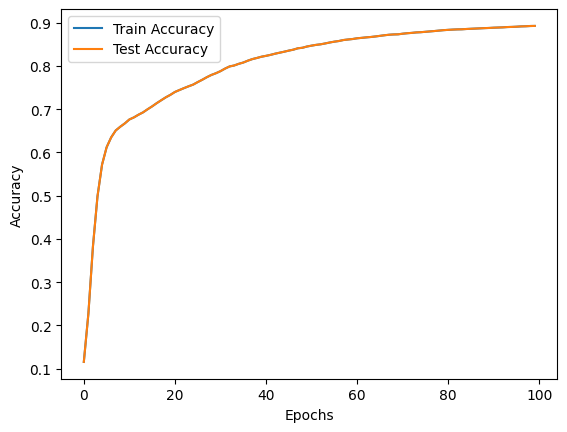

In [48]:

import matplotlib.pyplot as plt
import numpy as np

def plot_acc(train_accs, test_accs):
    epochs = np.arange(len(train_accs))
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_acc(train_accs, test_accs)


## [Log] Epoch 에 따른 Train Accuracy 와 Test Accuracy 시각화


# [Feedback] Train Accuracy

Train Accuracy 선 (파란선) 이 안보이는데 맞게 된건가요?